In [1]:
'''
author: Yike Xie
data: Jan/2024
content: kde plots for the manuscript
'''

'\nauthor: Yike Xie\ndata: Jan/2024\ncontent: kde plots for the manuscript\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}


In [4]:
def kdes(corr, fea, path=False):
    from matplotlib.lines import Line2D
    rcParams['pdf.fonttype'] = 42

    fig, ax = plt.subplots(figsize=[3,3])
    cs = sns.color_palette('tab10', 3)

    handles = []
    labels = []
    for i, c in zip([0, 10, 50], cs):
        sns.kdeplot(data=corr[corr['Number'] > i], x=fea, lw=2, 
                    ax=ax, c=c)
        handles.append(Line2D([], [], color=c, lw=2))
        labels.append('≥{} cells'.format(str(i)))

    ax.legend(handles=handles, labels=labels, loc='upper left', 
              bbox_to_anchor=[1, 1], title='Genes expressed by')
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')

    if path is not False:
        fig.savefig(path + '{}_kde_0_10_50.pdf'.format(fea), dpi=150, bbox_inches='tight')
        
def kde_fea(corr, n, fea, genes, colors, xlabel, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr[corr['Number'] > n], x=fea, lw=2, 
                ax=ax, c='gray')
    ax.set_title('Genes expressed by ≥{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(xlabel))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(gene, xy=(x, y), xytext=(x, y+0.8), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [5]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]
    
adata.obs['C4_C2'] = df[df.columns[3]] / df[df.columns[1]]

load features
load dataset
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## focus following analyses on cells with low percentage of mitochondrial reads

In [6]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [7]:
def plot_bins(adata, fea, bin_n, gene, cmap, xlabel, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 2.5])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)

    bins = np.array_split(adata.obs[fea].sort_values().array, 8)
    round_n = [0, 2]['.' in str(bins[0])]
#     round_n = 0
    xticklabels = [f'{f"%.{round_n}f" % (i.min())}-{f"%.{round_n}f" % (i.max())}' for i in bins]
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_xlabel(xlabel)
#     ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [8]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'
save_figures_C = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/C4/'
corr = pd.read_csv(save_figures + 'spectra_gene_correlation_live_cells.tsv', sep='\t', index_col=0).fillna(0)

In [9]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [16]:
n = 300
neg_list = corr[corr['Number'] >= 10]['343_451'].sort_values()[:n].index.tolist()
pos_list = corr[corr['Number'] >= 10]['343_451'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

# pathway analysis
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

pt_df_n.to_csv(save_figures + 'pathways_negative_correlate_C4.tsv', sep='\t')
pt_df_p.to_csv(save_figures + 'pathways_positive_correlate_C4.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-06 17:54:32,248 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-15-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

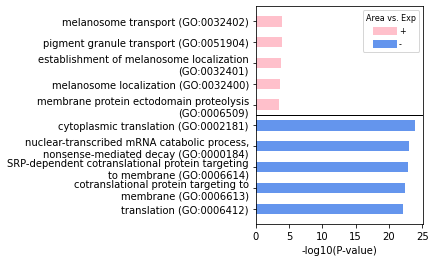

In [18]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + '300_genes_C4_pathway.pdf', dpi=150, bbox_inches='tight')
# Microtubules are cytoskeletal filaments central to a wide range of essential cellular 
    # functions in eukaryotic cells.
#

In [56]:
OXPHOS_fn = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/OxidativePhosphorylationGenes.xlsx'

OXPHOS_genes = pd.read_excel(OXPHOS_fn)['OXPHOS_genes'].tolist()
OXPHOS_genes = list(set(OXPHOS_genes) & set(corr.index))

## neg: 28 ## pos: 76
OXPHOS_show = corr.loc[OXPHOS_genes][['343_451']].sort_values('343_451')

# source: https://maayanlab.cloud/Enrichr/enrich 
# harmonizome_oxidative+phosphorylation_KEGG+Pathways (126 genes)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [C4 vs. Exp]', ylabel='Density'>}

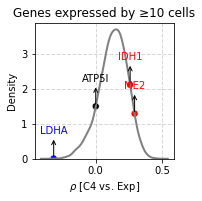

In [70]:
fea = '343_451'
genes = ['LDHA', 'ATP5I', 'IDH1', 'ME2']
colors = ['blue', 'black', 'red', 'red']
n = 10

kde_fea(corr, n, fea, genes, colors, 'C4', path=save_figures_C)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


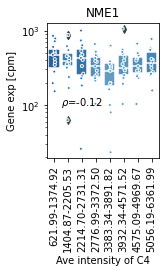

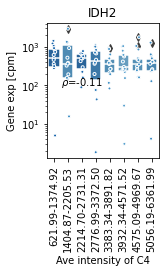

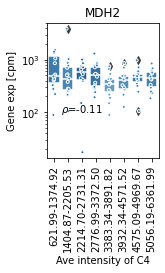

In [41]:
fea = '343_451' # '
# genes = ['LDHA', 'ATP5I', 'IDH1', 'ME2'] #  
# cmaps = ['Blues','Greys', 'Reds', 'Reds'] # 
genes = ['NME1', 'IDH2', 'MDH2'] #  
cmaps = ['Blues','Blues','Blues',] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ave intensity of C4', '.pdf', path=save_figures_C, rho=rho)

## C4 / C2

In [71]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/C4_C2/'
corr_ratio = pd.read_csv(save_figures + 'correlation_ratio_4_2_live_cells.tsv', sep='\t', index_col=0).fillna(0)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [C4/C2 vs. Exp]', ylabel='Density'>}

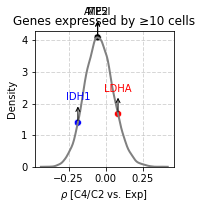

In [72]:
fea = 'C4_C2'
genes = ['LDHA', 'ATP5I', 'IDH1', 'ME2']
colors = ['red', 'black', 'blue', 'black']
n = 10

kde_fea(corr_ratio, n, fea, genes, colors, 'C4/C2', path=save_figures)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


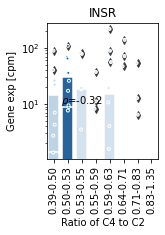

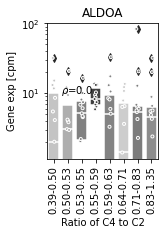

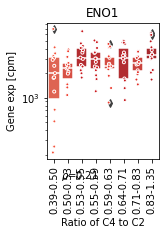

In [15]:
fea = 'C4_C2'
genes = ['INSR', 'ALDOA', 'ENO1',]
cmaps = ['Blues','Greys', 'Reds', ] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_ratio.loc[gene][fea]
    plot_bins(adata_live, fea, bin_n, gene, cmap, 'Ratio of C4 to C2', '.pdf', path=save_figures, rho=rho)

In [130]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 20:08:06,060 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-130-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resu

Text(0.5, 0, '-log10(P-value)')

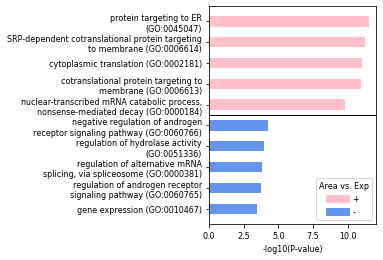

In [276]:
n = 300
neg_list = corr_ratio[corr_ratio['Number'] >= 10]['C4_C2'].sort_values()[:n].index.tolist()
pos_list = corr_ratio[corr_ratio['Number'] >= 10]['C4_C2'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

# pathway analysis
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

# pt_df_n.to_csv(save_figures + 'pathways_negative_corr_ratioelate_C4_C2.tsv', sep='\t')
# pt_df_p.to_csv(save_figures + 'pathways_positive_corr_ratioelate_C4_C2.tsv', sep='\t')

### plotting
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
# fig.savefig(save_figures + '300_genes_C4_C2_pathway.pdf', dpi=150, bbox_inches='tight')

In [248]:
pthws = {}
for gene_list, typei in zip([neg_list, pos_list], ['neg', 'pos']):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d
    pthw.to_csv(save_figures + 'C4_C2/' + f'{typei}_pathway_C4_C2.tsv', sep='\t')
    pthws[typei] = pthw

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 16:44:38,069 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-10-10 16:44:43,778 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False


- for positive pathways
19: gluconeogenesis (GO:0006094)
22: hexose biosynthetic process (GO:0019319)
29: positive regulation of ATP biosynthetic process (GO:2001171)
37: positive regulation of ATP metabolic process (GO:1903580)
41: glucose metabolic process (GO:0006006)
56: regulation of ATP biosynthetic process (GO:2001169)

- for negative pathways
28: regulation of glycolytic process (GO:0006110)
42: regulation of glycogen biosynthetic process (GO:0005979)
56: lipid phosphorylation (GO:0046834)
79: positive regulation of glycogen biosynthetic process (GO:0045725)
81: phosphorylation (GO:0016310)

Text(0.5, 0, '-log10(P-value)')

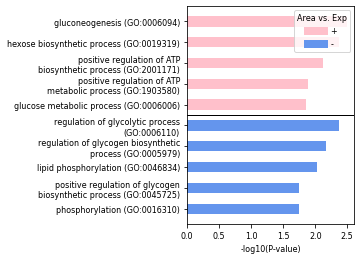

In [252]:
pthw_plot_mtb = pd.concat([pthws['pos'].iloc[[19, 22, 29, 37, 41]], pthws['neg'].iloc[[28, 42, 56, 79, 81]]])
pthw_plot_mtb['-log10(P-value)'] = -np.log10(pthw_plot_mtb['P-value'])

from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

ax.barh(range(10), pthw_plot_mtb['-log10(P-value)'][::-1], 
        height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
yticklabels = []
for i in pthw_plot_mtb['Term'][::-1]:
    if len(i.split(' ')) > 4:
        yticklabels.append(' '.join(i.split(' ')[:4]) + '\n' + ' '.join(i.split(' ')[4:]))
    else:
        yticklabels.append(i)
ax.set_yticklabels(yticklabels)

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', 
          loc='best', fontsize=8)

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + 'C4_C2/' + 'metabolic_pathways.pdf', dpi=300, bbox_inches='tight')

Hydrolase Regulates NAD+ Metabolites and Modulates Cellular Redox

doi: 10.1074/jbc.M809790200

doi: 10.1128/MCB.00032-12

In some cases the affinity of an ambiguous targeting signal to the different compartments can be changed by modification or binding of other proteins. An example for modification of an ambiguous targeting sequence can be found in the mammalian NADH–cytochrome b(5) reductase (b5R). This protein is localized both to the mitochondrial outer membrane and to the ER membrane. On the ER membrane it participates in different aspects of lipid metabolism via its function as an electron acceptor. On the mitochondrial outer membrane it mediates the regeneration of ascorbate from ascorbate free radical and is involved in transfer of electrons from cytosolic NADH to cytochrome c in the intermembrane space. This protein is translated from a single mRNA to create a single translation product, harboring an N-terminal targeting signal, required for both ER and mitochondrial targeting. This signal contains a moderately hydrophobic stretch of 14 amino acids that is preceded by a myristoylation consensus sequence, which is modified in about half of the molecules. In the absence of myristoylation, the nascent chain is bound to the SRP and is targeted to the ER. Myristoylation of the N-terminus lowers the affinity of the signal for SRP; the nascent chain remains on free polysomes and is imported post-translationally into the mitochondria [30].

https://www.sciencedirect.com/science/article/pii/S0005273610002385

! lipid metabolism

 https://doi.org/10.1016/0014-5793(93)81416-W

In [206]:
# glycolysis (KEGG 2021 Human)
# pentose phosphate pathway (KEGG 2021 Human)
# tricarboxylic acid (TCA) (Tricarboxylic acid (TCA) cycle and respiratory electron transport from BioPlanet_2019)
# oxidative phosphorylation (KEGG 2021 Human)

In [8]:
path_df = pd.read_excel('/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/MetabolicPathways.xlsx',)

In [12]:
path_genes_show = {}
for path in path_df.columns:
    gs = list(set(path_df[path].dropna()) & set(corr_ratio.index))
    gs = corr_ratio.loc[gs][corr_ratio.loc[gs]['Number'] >=10].index
    gs_show = corr_ratio.loc[gs][['C4_C2']].sort_values('C4_C2') 
    path_genes_show[path] = gs_show
    
    print(f'Pathway {path} has {str(len(gs))} genes')
    p_n = (gs_show['C4_C2'] > 0).sum()
    print(f'{str(p_n)} positive correlated with C4_C2 and gene exp')
    print(f'{str(len(gs) - p_n)} negative correlated with C4_C2 and gene exp')
    print('____________________________________________')

Pathway OXPHOS has 104 genes
33 positive correlated with C4_C2 and gene exp
71 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway Glycolysis has 40 genes
19 positive correlated with C4_C2 and gene exp
21 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway Pentose phosphate has 22 genes
7 positive correlated with C4_C2 and gene exp
15 negative correlated with C4_C2 and gene exp
____________________________________________
Pathway TCA cycle has 110 genes
38 positive correlated with C4_C2 and gene exp
72 negative correlated with C4_C2 and gene exp
____________________________________________


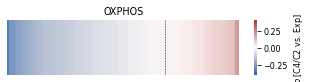

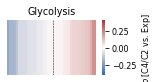

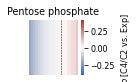

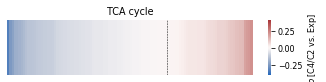

In [63]:
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

for path in path_df.columns:
    gs_number = path_genes_show[path].shape[0]
    fig, ax = plt.subplots(figsize=[gs_number/20, 1])
    sns.heatmap(path_genes_show[path].T, center=0, cmap='vlag', vmin = -0.4, vmax=0.4, 
                cbar_kws={'label': r'$\rho$ [{} vs. Exp]'.format('C4/C2')})
    
    pos_gene = path_genes_show[path].T.columns[path_genes_show[path].T.loc['C4_C2'] > 0][0]
    pos_genei = path_genes_show[path].T.columns.tolist().index(pos_gene)
    ax.axvline((2* pos_genei -1) / 2, c='k', ls='--', lw=0.5)
    
    ax.set_xlabel(None)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title(path)

    plt.savefig(save_figures + f'{path}_C4_C2.pdf', 
                bbox_inches='tight', dpi=300)
    plt.savefig(save_figures + f'{path}_C4_C2.pdf',
                bbox_inches='tight', dpi=300)

### with NADH/NAD+ ratio

Our studies suggest that the fluorescence lifetime of both the free and the protein-bound components of NADH and the ratio of free to protein-bound NADH is related to changes in the NADH/NAD+ ratio.

Biochemical estimation of NADH concentration is a useful method for monitoring cellular metabolism, because the NADH/NAD+ reduction-oxidation pair is crucial for electron transfer in the mitochondrial electron chain. 

https://doi.org/10.1158/0008-5472.CAN-04-3922

A shift toward the higher free NADH is indicative of a more glycolytic metabolism and a reverse shift is indicative of more oxidative phosphorylation.
 
Free and protein bound NADH have been used often to noninvasively predict or determine the changes in cellular metabolism

the ratio of NAD+/NADH can be correlated to free and bound NADH and these two NADH species have very different lifetimes

https://doi.org/10.1002/jbio.201900156


# metabolism genes

In [28]:
meta_genes = pd.read_excel('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/Metabolism Gene List.xlsx',
                          sheet_name='Sheet2', index_col=0)
meta_genes_in = meta_genes.loc[[gene for gene in meta_genes.index if gene in corr.index]]
meta_genes_in['ρ [Channel 4 vs Gene exp]'] = corr.loc[meta_genes_in.index]['343_451']
meta_genes_in['ρ [C4/C2 vs Gene exp]'] = corr_ratio.loc[meta_genes_in.index]['C4_C2']
meta_genes_in.to_csv('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/Metabolism Gene Correlation Coefficient.tsv',
                    sep='\t')

In [14]:
meta_genes_in = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/' + 
                            'Attachment1 Metabolism Gene Correlation Coefficient.tsv', index_col=0, sep='\t')
meta_genes_in = meta_genes_in[~ meta_genes_in.duplicated()]

meta_genes_dic = {}
for pathway in meta_genes_in['Pathways'].unique():
    meta_genes_dic[pathway] = meta_genes_in[meta_genes_in['Pathways'] == pathway]
    meta_genes_dic[pathway] = meta_genes_dic[pathway][~ meta_genes_dic[pathway].duplicated()]
    
meta_genes_dic['All genes'] = meta_genes_in
meta_genes_dic['All metabolic genes'] = meta_genes_in

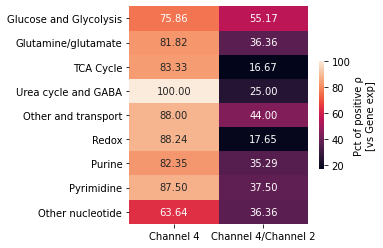

In [137]:
pct_df = pd.DataFrame(index=meta_genes_dic.keys(), 
                      columns=['pct of pos ρ [Channel 4 vs Gene exp]',
                               'pct of pos ρ [C4/C2 vs Gene exp]'])

feas = ['ρ [Channel 4 vs Gene exp]', 'ρ [C4/C2 vs Gene exp]']

for key in meta_genes_dic.keys():
    for fea in feas:
        pct_df.loc[key, 'pct of pos ' + fea] = round((meta_genes_dic[key][fea] > 0).sum() * 100 / meta_genes_dic[key].shape[0], 2)

for i in [0, 1]:
    pct_df[pct_df.columns[i]] = pd.to_numeric(pct_df[pct_df.columns[i]])   
    
pct_df = pct_df.loc[
    [
        'Glucose and Glycolysis',
        'Glutamine/glutamate',
        'TCA Cycle', 
        'Urea cycle and GABA',
        'Other and transport',
        'Redox', 
        'Purine',
        'Pyrimidine', 
        'Other nucleotide',   
    ]
]

fig, a = plt.subplots(figsize=[4, 4])
ax = sns.heatmap(pct_df, fmt='.2f', annot = True,
                 cbar_kws={
                     'label': 'Pct of positive ρ\n[vs Gene exp]', 'shrink': 0.5})
ax.set_xticklabels(['Channel 4', 'Channel 4/Channel 2'], rotation=0)

fig.savefig('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/' + 'pct_pos_heatmap.png', 
            bbox_inches='tight', dpi=300)

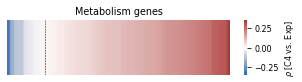

In [85]:
# plot all metabolism genes [channel 4 vs gene exp]
all_meta_genes = meta_genes_in.index.unique().tolist()
all_meta_C4 = meta_genes_in[['ρ [Channel 4 vs Gene exp]']][~ meta_genes_in[['ρ [Channel 4 vs Gene exp]']].duplicated()]
heatmap_all_meta = all_meta_C4.loc[all_meta_genes].sort_values('ρ [Channel 4 vs Gene exp]')

rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=[5, 1])
sns.heatmap(heatmap_all_meta.T, center=0, cmap='vlag', vmin = -0.35, vmax=0.35, 
            cbar_kws={'label': r'$\rho$ [{} vs. Exp]'.format('C4')})

ax.set_xlabel(None)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('Metabolism genes')

neg_gene_n = (heatmap_all_meta['ρ [Channel 4 vs Gene exp]'] < 0).sum()
ax.axvline((2 * neg_gene_n -1) / 2, c='k', ls='--', lw=0.5)

plt.savefig(save_figures_C + 'All_metabolism_genes_C4.pdf', bbox_inches='tight', dpi=300)
plt.savefig(save_figures_C + 'All_metabolism_genes_C4.png', bbox_inches='tight', dpi=300)

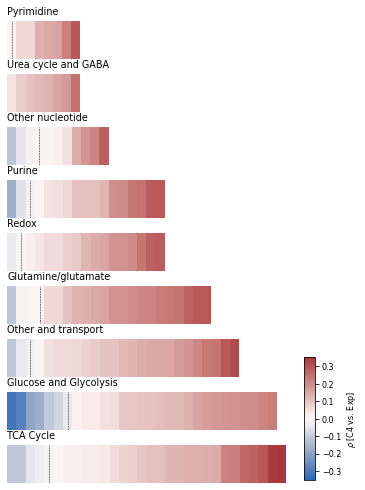

In [168]:
# show the correlation coefficients in each pathway by heatmap
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8
import matplotlib.gridspec as gridspec

pathways = meta_genes_in['Pathways'].unique()
sorted_items = sorted({path: meta_genes_dic[path].shape[0] for path in pathways}.items(), key=lambda x:x[1])
pathways = [i[0] for i in sorted_items]

fig = plt.figure(figsize=(5, 8.5))
max_path_n = max([meta_genes_dic[path].shape[0] for path in pathways])
grid = plt.GridSpec(len(pathways), max_path_n)

axs = []
for i, path in enumerate(pathways):
     axs.append(plt.subplot(grid[i: i + 1, 0: meta_genes_dic[path].shape[0]]))
        
plt.subplots_adjust(hspace=0.4)

for i, path in enumerate(pathways):
    meta_genes_df = meta_genes_in[meta_genes_in['Pathways'] == path]
    meta_genes_df = meta_genes_df[~ meta_genes_df.duplicated()][['ρ [Channel 4 vs Gene exp]']].sort_values('ρ [Channel 4 vs Gene exp]')
   
    gs_number = meta_genes_df.shape[0]
    sns.heatmap(meta_genes_df.T, center=0, cmap='vlag', vmin = -0.35, vmax=0.35, 
                cbar=False, ax=axs[i])
    
    neg_gene_n = (meta_genes_df['ρ [Channel 4 vs Gene exp]'] < 0).sum()
    axs[i].axvline((2 * neg_gene_n -1) / 2, c='k', ls='--', lw=0.5)
    
    axs[i].set_xlabel(None)
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_title(path, loc='left')
    
norm = mpl.colors.Normalize(vmin=-0.35, vmax=0.35) 
cmap = plt.cm.get_cmap('vlag')
position = fig.add_axes([0.95, 0.13, 0.03, 0.2])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                    cax=position, ax=axs[0], label=r'$\rho$ [{} vs. Exp]'.format('C4'))

plt.savefig(save_figures_C + 'path_genes_C4.pdf', 
            bbox_inches='tight', dpi=300)
plt.savefig(save_figures_C + 'path_genes_C4.png',
            bbox_inches='tight', dpi=300)

<ipython-input-27-0a0436b4bfbe>:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


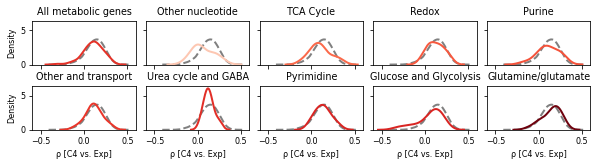

In [27]:
# show the correlation coefficients in each pathway by kdeplot
# dash line is peak line

rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

from scipy.stats.kde import gaussian_kde

fig, axs = plt.subplots(2, 5, figsize=(10, 2), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

cmap = mpl.cm.get_cmap('Reds')
pathways = meta_genes_in['Pathways'].unique().tolist()

kde_xs = {}
colors = {}
for path in ['All metabolic genes'] + pathways:
    nparam_density = gaussian_kde(meta_genes_dic[path]['ρ [Channel 4 vs Gene exp]'])
    x = np.linspace(-0.35, 0.35, 200)
    nparam_density = nparam_density(x)
    kde_xs[path] = x[nparam_density.argmax()]
    colors[path] = cmap(0.2 + 0.8 * kde_xs[path]/0.2)
    
kde_pathways = ['All metabolic genes'] + [i[0] for i in sorted(kde_xs.items(), key=lambda x:x[1]) if i[0] != 'All metabolic genes']    

for i, path in enumerate(kde_pathways):
    sns.kdeplot(data=corr[['343_451']], x='343_451', lw=2, ax=axs[i], ls='--', c='grey')
    
    meta_genes_df = meta_genes_dic[path][['ρ [Channel 4 vs Gene exp]']]
    sns.kdeplot(data=meta_genes_df, x='ρ [Channel 4 vs Gene exp]', lw=2, ax=axs[i], c=colors[path])
#     for j in [-0.5, 0, 0.5]:
#         axs[i].axvline(j, lw=1, ls='--', zorder=-5, alpha=0.5, color='lightgrey')
    axs[i].set_title(path)
#     axs[i].axvline(kde_xs[path], c=colors[path], ls='--', lw=1.5)

for i in [0, 5]:
    axs[i].set_ylabel('Density')

for i in range(10)[::1]:
    axs[i].set_xlabel('ρ [C4 vs. Exp]')
    
plt.savefig(save_figures_C + 'path_genes_C4_kde.pdf', 
            bbox_inches='tight', dpi=300)
plt.savefig(save_figures_C + 'path_genes_C4_kde.png',
            bbox_inches='tight', dpi=300)

In [38]:
from scipy.stats import ks_2samp
ks_paths = {}
for path in pathways:
    res = ks_2samp(meta_genes_dic[path]['ρ [Channel 4 vs Gene exp]'], corr['343_451'], 
                   alternative='two-sided', method='asymp')
    ks_paths[path] = [res.statistic, res.pvalue]

In [39]:
# energy metabolism:   'Glucose and Glycolysis',  'TCA Cycle',  'Redox', 'Glutamine/glutamate'
# Nucleotide metabolism:   'Purine', 'Pyrimidine',  'Other nucleotide',
# Nitrogen Metabolism and Neurotransmitter Synthesis: 'Urea cycle and GABA'
# General and Transport: 'Other and transport',

<ipython-input-28-e6535e209bf6>:7: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


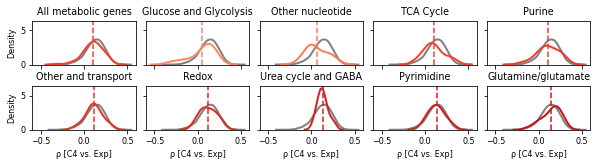

In [28]:
# show the correlation coefficients in each pathway by kdeplot
# dash line is average

rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 8

from scipy.stats.kde import gaussian_kde

fig, axs = plt.subplots(2, 5, figsize=(10, 2), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.1)
axs = axs.ravel()

cmap = mpl.cm.get_cmap('Reds')
pathways = meta_genes_in['Pathways'].unique().tolist()

kde_xs = {}
colors = {}
for path in ['All metabolic genes'] + pathways:
    kde_xs[path] = meta_genes_dic[path]['ρ [Channel 4 vs Gene exp]'].mean()
    colors[path] = cmap(0.2 + 0.8 * kde_xs[path]/0.2)
    
kde_pathways = ['All metabolic genes'] + [i[0] for i in sorted(kde_xs.items(), key=lambda x:x[1]) if i[0] != 'All metabolic genes']    

for i, path in enumerate(kde_pathways):
    sns.kdeplot(data=corr[['343_451']], x='343_451', lw=2, ax=axs[i], c='grey')
    
    meta_genes_df = meta_genes_dic[path][['ρ [Channel 4 vs Gene exp]']]
    sns.kdeplot(data=meta_genes_df, x='ρ [Channel 4 vs Gene exp]', lw=2, ax=axs[i], c=colors[path])
#     axs[i].grid(lw=1, ls='--', zorder=-5, alpha=0.5)
    axs[i].set_title(path)
    axs[i].axvline(kde_xs[path], c=colors[path], ls='--', lw=1.5)

for i in [0, 5]:
    axs[i].set_ylabel('Density')

for i in range(10)[::1]:
    axs[i].set_xlabel('ρ [C4 vs. Exp]')
    
plt.savefig(save_figures_C + 'path_genes_C4_kde3.pdf', 
            bbox_inches='tight', dpi=300)
plt.savefig(save_figures_C + 'path_genes_C4_kde3.png',
            bbox_inches='tight', dpi=300)

In [155]:
# filter some genes for Jeff
from collections import defaultdict
filtered_genes = defaultdict(list)
feas = ['ρ [Channel 4 vs Gene exp]', 'ρ [C4/C2 vs Gene exp]']

for fea in feas:
    filtered_genes[fea] += meta_genes_in.sort_values(fea).head(3).index.tolist()
    filtered_genes[fea] += meta_genes_in.sort_values(fea).tail(3).index.tolist()
    
meta_genes_in_f0 = meta_genes_in[['Pathways', feas[0]]].loc[filtered_genes[feas[0]]]
meta_genes_in_f1 = meta_genes_in[['Pathways', feas[1]]].loc[filtered_genes[feas[1]]]
meta_genes_in_f = pd.concat([meta_genes_in_f0, meta_genes_in_f1])
meta_genes_in_f.to_csv('/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/tables/' +
                      'filtered_metabolism_genes.tsv', sep='\t')
meta_genes_in_f

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
LDHA,Glucose and Glycolysis,-0.316846,NaN
TPI1,Glucose and Glycolysis,-0.287958,NaN
GAPDH,Glucose and Glycolysis,-0.194808,NaN
H6PD,Other and transport,0.312764,NaN
PDHA1,TCA Cycle,0.343911,NaN
SUCLG2,TCA Cycle,0.348437,NaN
PDP1,Other and transport,NaN,-0.256618
DNMT3A,Redox,NaN,-0.230110
GPI,Glucose and Glycolysis,NaN,-0.213676


In [93]:
meta_genes_in[['Pathways','ρ [Channel 4 vs Gene exp]']][abs(meta_genes_in['ρ [Channel 4 vs Gene exp]']) > 0.2].sort_values(['Pathways', 'ρ [Channel 4 vs Gene exp]'])

,Pathways,ρ [Channel 4 vs Gene exp]
Genes,,
LDHA,Glucose and Glycolysis,-0.316846
TPI1,Glucose and Glycolysis,-0.287958
SLC2A10,Glucose and Glycolysis,0.212419
HK2,Glucose and Glycolysis,0.222043
SLC38A1,Glutamine/glutamate,0.207555
GFPT2,Glutamine/glutamate,0.209184
SLC7A5,Glutamine/glutamate,0.225172
PPAT,Glutamine/glutamate,0.234726
PPAT,Glutamine/glutamate,0.234726


In [92]:
meta_genes_in[['Pathways','ρ [C4/C2 vs Gene exp]']][abs(meta_genes_in['ρ [C4/C2 vs Gene exp]']) > 0.2].sort_values(['Pathways', 'ρ [C4/C2 vs Gene exp]'])

,Pathways,ρ [C4/C2 vs Gene exp]
Genes,,
GPI,Glucose and Glycolysis,-0.213676
GAPDH,Glucose and Glycolysis,0.213047
ENO1,Glucose and Glycolysis,0.213987
PDP1,Other and transport,-0.256618
HIF1A,Other and transport,0.257078
ATIC,Purine,0.202740
DNMT3A,Redox,-0.230110
GCLC,Redox,-0.210611
IDH2,TCA Cycle,0.215417


In [78]:
# -0.31-0.35 # 69 genes have rho between -0.1 and 0.1
  # only 33 have negative rhos
  # means that MCF-7 cells with brighter channel 4 have more active metabolism
# -0.25 - 0.25 # 134 genes have rho between -0.1 and 0.1
  # 121 have negative rhos
(meta_genes_in['ρ [C4/C2 vs Gene exp]'] < 0).sum()

121

In [50]:
meta_genes_dic['Purine'].sort_values('ρ [Channel 4 vs Gene exp]')

## only ATIC is strongly negative correlated with channel 4.

# ATIC encodes a bifunctional protein that catalyzes the last two steps of the de novo purine biosynthetic pathway
# negative to channel 4, and positive to C4/C2 (0.20)

# PPAT (Phosphoribosyl Pyrophosphate Amidotransferase) catalyzes the first step of de novo purine nucleotide biosythetic pathway
# PFAS and GART are both Phosphoribosylformylglycinamidine Synthase, required for de novo purine biosynthesis
# positive to channel 4, and PFAS is negative to C4/C2 (-0.15)

# PHGDH and PSPH, early and third and last setp in L-serine formation
# positive to channel 4

# IMPDH1 and IMPDH2 positive related with channel 4
  # an enzyme that catalyzes the synthesis of xanthine monophosphate (XMP) from inosine-5'-monophosphate (IMP),
  # which is the rate-limiting step in the de novo synthesis of guanine nucleotides.

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
ATIC,Purine,-0.171693,0.202740
ADSL,Purine,-0.057086,-0.100644
GMPS,Purine,-0.021799,0.020224
SHMT1,Purine,0.010539,0.126393
SHMT2,Purine,0.045649,-0.023623
PAICS,Purine,0.051191,0.023600
G6PD,Purine,0.065026,-0.020885
ADSS,Purine,0.101506,-0.071860
PRPS1,Purine,0.102932,-0.032206


In [57]:
meta_genes_dic['Pyrimidine'].sort_values('ρ [Channel 4 vs Gene exp]')

# all non negative with channel 4

# CTPS2: UTP to CTP & glutamine to glutamate
# TYMS: deoxyuridylate (dUMP) to deoxythymidylate (dTMP)

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
CTPS1,Pyrimidine,-0.004319,-0.027707
GOT1,Pyrimidine,0.060504,-0.064442
UMPS,Pyrimidine,0.063927,-0.090302
GOT2,Pyrimidine,0.133028,0.066337
DHODH,Pyrimidine,0.145675,0.061723
CAD,Pyrimidine,0.155365,-0.158722
TYMS,Pyrimidine,0.213388,0.035211
CTPS2,Pyrimidine,0.290721,-0.069442


In [53]:
meta_genes_dic['Glutamine/glutamate'].sort_values('ρ [Channel 4 vs Gene exp]')

# CTPS2: UTP to CTP & glutamine to glutamate

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
GLUD2,Glutamine/glutamate,-0.115141,-0.003253
GMPS,Glutamine/glutamate,-0.021799,0.020224
GLUD1,Glutamine/glutamate,-0.005441,0.124557
CTPS1,Glutamine/glutamate,-0.004319,-0.027707
GOT1,Glutamine/glutamate,0.060504,-0.064442
SLC1A5,Glutamine/glutamate,0.060607,-0.145450
GPT2,Glutamine/glutamate,0.100806,0.049519
OAT,Glutamine/glutamate,0.126812,0.039303
GOT2,Glutamine/glutamate,0.133028,0.066337


In [58]:
meta_genes_dic['Glucose and Glycolysis'].sort_values('ρ [Channel 4 vs Gene exp]')

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
LDHA,Glucose and Glycolysis,-0.316846,0.082855
TPI1,Glucose and Glycolysis,-0.287958,0.081477
GAPDH,Glucose and Glycolysis,-0.194808,0.213047
ENO1,Glucose and Glycolysis,-0.174712,0.213987
PGAM1,Glucose and Glycolysis,-0.111341,0.096855
ALDOA,Glucose and Glycolysis,-0.083581,0.003454
PKM,Glucose and Glycolysis,-0.041376,0.079383
ENO3,Glucose and Glycolysis,0.013305,-0.108195
GPI,Glucose and Glycolysis,0.030411,-0.213676


In [59]:
a = 'TCA Cycle'
meta_genes_dic[a].sort_values('ρ [Channel 4 vs Gene exp]')

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
IDH2,TCA Cycle,-0.114140,0.215417
MDH2,TCA Cycle,-0.109658,0.176942
SDHA,TCA Cycle,-0.050699,-0.092143
CS,TCA Cycle,-0.032103,-0.082941
MPC1,TCA Cycle,-0.017388,-0.148113
SDHC,TCA Cycle,0.000011,-0.073167
SUCLG1,TCA Cycle,0.021137,0.042495
ME1,TCA Cycle,0.021528,-0.061627
SDHB,TCA Cycle,0.028622,-0.196490


In [60]:
a = 'Urea cycle and GABA'
meta_genes_dic[a].sort_values('ρ [Channel 4 vs Gene exp]')

# ALDH5A1 and ALDH18A1 
  # both are mitochondrial NAD(+)-dependent enzyme
  # ALDH5A1:Catalyzes one step in the degradation of GABA
  # ALDH18A1: converts glutamate to glutamate 5-semialdehyde, an intermediate in the biosynthesis of proline, ornithine and arginine

# https://www.researchgate.net/figure/The-role-of-ALDH-isozymes-in-glutamate-and-GABA-pathways_fig6_5241912

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
ASS1,Urea cycle and GABA,0.042521,-0.003895
ASL,Urea cycle and GABA,0.083348,0.013531
GAD1,Urea cycle and GABA,0.101465,-0.133834
PYCR1,Urea cycle and GABA,0.113131,-0.052050
OAT,Urea cycle and GABA,0.126812,0.039303
ABAT,Urea cycle and GABA,0.152216,-0.011174
ALDH18A1,Urea cycle and GABA,0.169821,-0.115713
ALDH5A1,Urea cycle and GABA,0.244084,-0.075164


In [61]:
a = 'Redox'
meta_genes_dic[a].sort_values('ρ [Channel 4 vs Gene exp]')

# GCLC negative with C4/C2 -0.21 
  # Catalyzes the ATP-dependent ligation of L-glutamate and L-cysteine and participates in the first and rate-limiting step in glutathione biosynthesis
# DNMT3A, DNMT3B negative with C4/C2 -0.23, -0.17
  #  for DNA methylation
# SLC7A11 and MAT2A negative with C4/C2 -0.16, -0.17
  # SLC7A11: exchange of extracellular anionic L-cystine and intracellular L-glutamate across the cellular plasma membrane
  # MAT2A: Catalyzes the formation of S-adenosylmethionine from methionine and ATP

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
MTHFD2,Redox,-0.040218,-0.030405
MTHFR,Redox,-0.011598,-0.058344
GCLM,Redox,0.023589,-0.098892
DHFR,Redox,0.038414,-0.053912
DNMT3B,Redox,0.055903,-0.178046
DNMT1,Redox,0.058424,-0.098319
GCLC,Redox,0.078756,-0.210611
CTH,Redox,0.086540,0.058417
MTHFD1,Redox,0.121742,-0.086507


In [62]:
a = 'Other nucleotide'
meta_genes_dic[a].sort_values('ρ [Channel 4 vs Gene exp]')

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
NME1,Other nucleotide,-0.122654,0.178661
CMPK1,Other nucleotide,-0.047823,-0.026913
UPP1,Other nucleotide,-0.021279,-0.083419
RRM2,Other nucleotide,-0.004560,0.049538
UCK2,Other nucleotide,0.011449,-0.028463
UCKL1,Other nucleotide,0.016672,-0.105146
TK1,Other nucleotide,0.044030,0.189671
RRM1,Other nucleotide,0.138234,-0.001142
UCK1,Other nucleotide,0.180168,0.005774


In [63]:
a = 'Other and transport'
meta_genes_dic[a].sort_values('ρ [Channel 4 vs Gene exp]')

,Pathways,ρ [Channel 4 vs Gene exp],ρ [C4/C2 vs Gene exp]
Genes,,,
SLC25A11,Other and transport,-0.112401,-0.009939
DPYD,Other and transport,-0.042142,0.055939
GGCT,Other and transport,-0.029301,0.056260
FBP1,Other and transport,0.004135,-0.010664
HIF1A,Other and transport,0.047015,0.257078
SLC1A4,Other and transport,0.055332,-0.056422
SLC25A1,Other and transport,0.059318,0.173206
PCK2,Other and transport,0.063170,-0.048609
DCTD,Other and transport,0.073378,-0.076716
